In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import datetime

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *


In [3]:
n = 500
k = 30
avgGenesInPath = 100
numReps = 50
intersectionGap = 1
numPlotPoints = 100
gene_num_list = [1000, 3000, 5000, 7000]

In [19]:
# def DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes):
#     df = pd.DataFrame(X.T)
#     is_gene = np.ones(g)
#     is_gene[0] = 0
#     phenotype_gene_col = np.zeros(g)
#     phenotype_gene_col[phenotypeGenes] = 1
    
#     df['is_gene'] = is_gene
#     df['phenotype_genes'] = phenotype_gene_col
    
#     df = pd.concat([df, pd.DataFrame(binaryPathwayMatrix, columns=['pathway{}'.format(i) for i in range(binaryPathwayMatrix.shape[1])])], axis=1)
#     return df

In [20]:
# for i in range(50):
#     for g in gene_num_list:
#         U, V, binaryPathwayMatrix, phenotypeGenes = GenerateSimulatedData(n, g, k, int(g/avgGenesInPath), avgGenesInPath, covariateU=True)
#         X = np.dot(U, V.T)
#         df = DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes)
#         df.to_csv('/projects/leelab3/psturm/simulatedData/varyDimData/g{}/df{}.csv'.format(g, i), index=False)

In [5]:
baseParamDir = '../../DataFrames/'

In [ ]:
def GetMeanErrorDF(errorsDF, num_folds=5):
    meanErrorsDF = pd.concat([errorsDF[errorsDF['fold'] == i].drop('fold', axis=1).reset_index(drop=True) for i in range(num_folds)], axis=0)
    meanErrorsDF = meanErrorsDF.groupby(meanErrorsDF.index).mean()
    return meanErrorsDF

In [10]:
for g in [1000, 3000, 5000, 7000]:
    errorsDF = pd.read_csv(baseParamDir + 'errorsDF_g{}.csv'.format(g), header=0)
    meanErrorsDf = GetMeanErrorDF(errorsDF)
    bestParamsIndex = meanErrorsDf['error'].idxmin(axis=1)
    print('------G: {}------'.format(g))
    print(meanErrorsDf.iloc[bestParamsIndex])

------G: 1000------
eta      0.006872
lamb1    0.001322
lamb2    0.013549
error    0.552870
Name: 17, dtype: float64
------G: 3000------
eta      0.004405
lamb1    0.018094
lamb2    0.009637
error    0.557688
Name: 7, dtype: float64
------G: 5000------
eta      0.003169
lamb1    0.007227
lamb2    0.016451
error    0.493712
Name: 14, dtype: float64
------G: 7000------
eta      0.003933
lamb1    0.004865
lamb2    0.010235
error    0.665703
Name: 43, dtype: float64


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


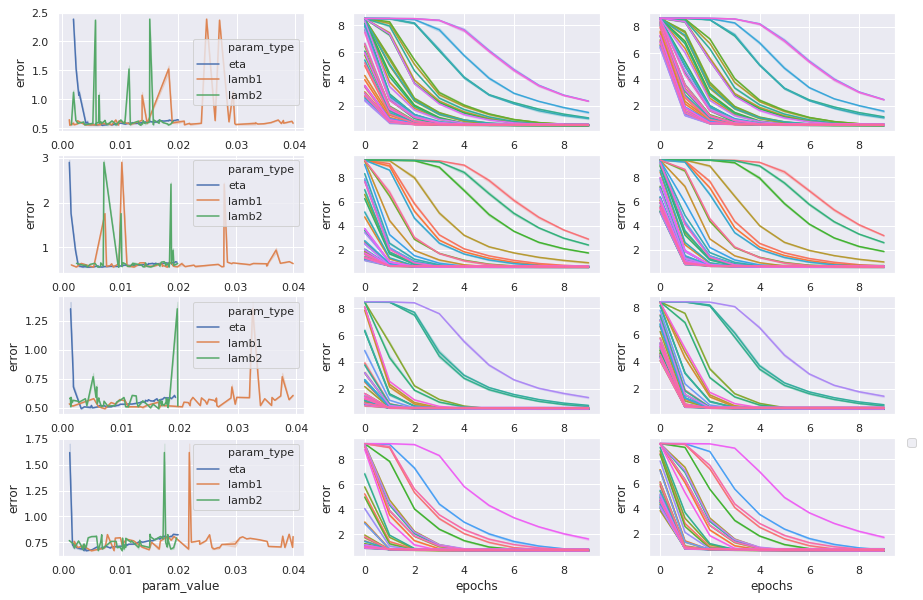

In [11]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
i = 0
for g in [1000, 3000, 5000, 7000]:
    errorsDF = pd.read_csv(baseParamDir + 'errorsDF_g{}.csv'.format(g), header=0)
    PlotParamDF(errorsDF, ax=axs[i, 0])
    
    testErrorDF = pd.read_csv(baseParamDir + 'testErrorDF_g{}.csv'.format(g), header=0)
    PlotErrorDF(testErrorDF, ax=axs[i, 1])
    
    trainErrorDF = pd.read_csv(baseParamDir + 'trainErrorDF_g{}.csv'.format(g), header=0)
    PlotErrorDF(trainErrorDF, ax=axs[i, 2])
    
    i += 1

In [4]:
dataFileBase = '/projects/leelab3/psturm/simulatedData/varyDimData/g{}/df{}.csv'
def ApplyIntersection(predList, trueList, g, intersectionGap):
    numPlotPoints = int(g / intersectionGap)
    intersection_list = np.zeros((numPlotPoints))
    index = 0
    for i in range(0, g, intersectionGap):
        intersection_list[index] = np.sum(np.in1d(predList[i:i+intersectionGap], trueList))
        index += 1
    return intersection_list
    
def GetIntersections(rep):
    print(rep, end=',')
    intersection_mat = np.zeros((len(4 * gene_num_list), numPlotPoints))
    
    i = 0
    for g in gene_num_list:
        df = pd.read_csv(dataFileBase.format(g, rep))
        X, _, phenotypeGenes = DFtoDataset(df)

        U_pred = np.load('/projects/leelab3/psturm/simulatedModels/geneModels/g{}/U{}.npy'.format(g, rep))
        V_pred = np.load('/projects/leelab3/psturm/simulatedModels/geneModels/g{}/V{}.npy'.format(g, rep))
        
        intersection_mat[4 * i, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='dot'),  phenotypeGenes, g, int(g/100))
        intersection_mat[4 * i + 1, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='corr'), phenotypeGenes, g, int(g/100))
        intersection_mat[4 * i + 2, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='cos'),  phenotypeGenes, g, int(g/100))
        intersection_mat[4 * i + 3, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='dist', sortFunc=None), phenotypeGenes, g, int(g/100))

        intersection_mat[(4 * i):(4*i + 4), :] /= len(phenotypeGenes)
        i = i + 1
    return intersection_mat

In [5]:
tg_zipped = map(GetIntersections, range(numReps))

In [6]:
tg_stacked = np.stack(tg_zipped, axis=0) #of shape numReps, 4, numPlotPoints
tg_summed  = np.cumsum(tg_stacked, axis=2) #cumulative sum over numPlotPoints

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

In [7]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

In [9]:
tg_summed.shape

(50, 16, 100)

In [17]:
enet_dfs = []
sgl_dfs  = []
regDFDir = '../../DataFrames/latentRegression/numGenes_{}_g{}.csv'
for g in gene_num_list:
    x_values = np.arange(int(g)) / g
    elastic_net_mat = pd.read_csv(regDFDir.format('enet', g)).values.T
    elastic_net_df  = MatToMeltDF(elastic_net_mat, group_name='enet_g{}'.format(g), x_values=x_values)
    enet_dfs.append(elastic_net_df)
        
    sgl_mat = pd.read_csv(regDFDir.format('sgl', g)).values.T
    sgl_df  = MatToMeltDF(sgl_mat, group_name='sgl_g{}'.format(g), x_values=x_values)
    sgl_dfs.append(sgl_df)

In [15]:
x_values = np.arange(100)/100
names = ['g1000_dist', 'g3000_dist', 'g5000_dist', 'g7000_dist']
indices = [3, 7, 11, 15]
dfs = []
for i in range(len(indices)):
    dfs.append(MatToMeltDF(tg_summed[:, indices[i], :], group_name = names[i], x_values=x_values))

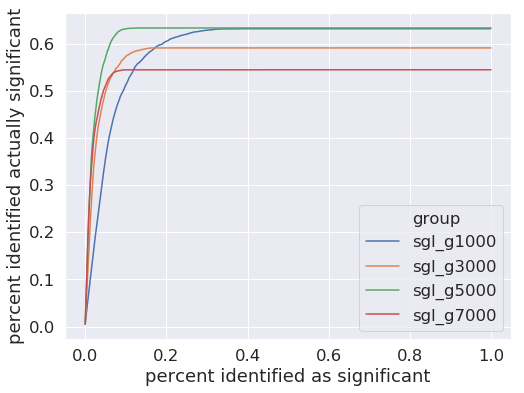

In [22]:
sns.lineplot(x='percent identified as significant', y='percent identified actually significant', hue='group', 
             data=pd.concat(sgl_dfs), ci=None)

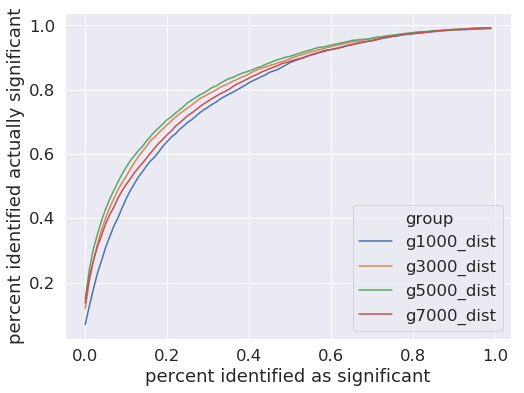

In [8]:
plotIndices(tg_summed, ['g1000_dist', 'g3000_dist', 'g5000_dist', 'g7000_dist'], [3, 7, 11, 15], np.arange(100)/100)

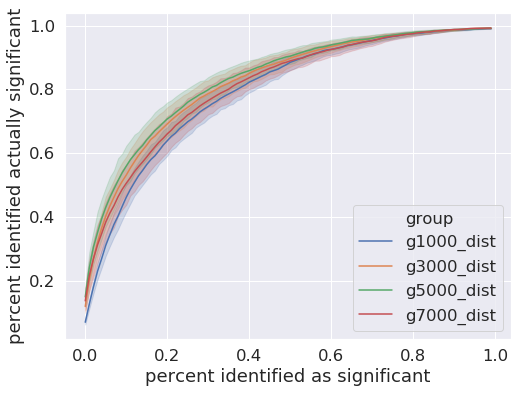

In [65]:
plotIndices(tg_summed, ['g1000_dist', 'g3000_dist', 'g5000_dist', 'g7000_dist'], [3, 7, 11, 15], np.arange(100)/100, ci=95)

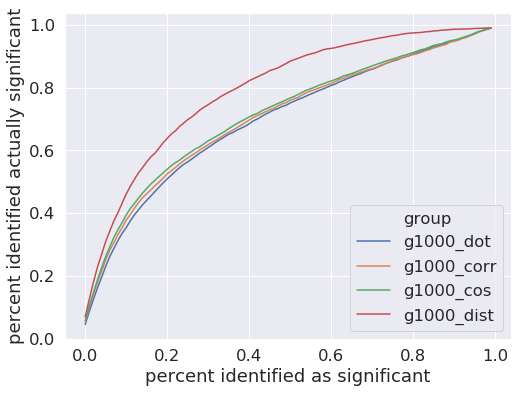

In [66]:
plotIndices(tg_summed, ['g1000_dot', 'g1000_corr', 'g1000_cos', 'g1000_dist'], range(4), np.arange(100)/100)

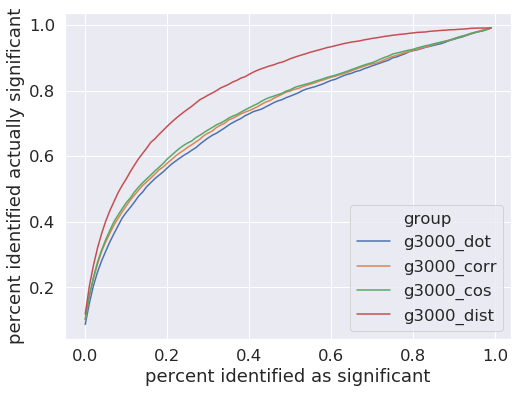

In [67]:
plotIndices(tg_summed, ['g3000_dot', 'g3000_corr', 'g3000_cos', 'g3000_dist'], range(4, 8), np.arange(100)/100)

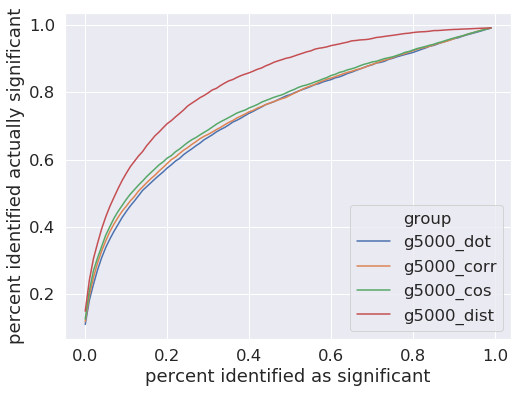

In [68]:
plotIndices(tg_summed, ['g5000_dot', 'g5000_corr', 'g5000_cos', 'g5000_dist'], range(8, 12), np.arange(100)/100)

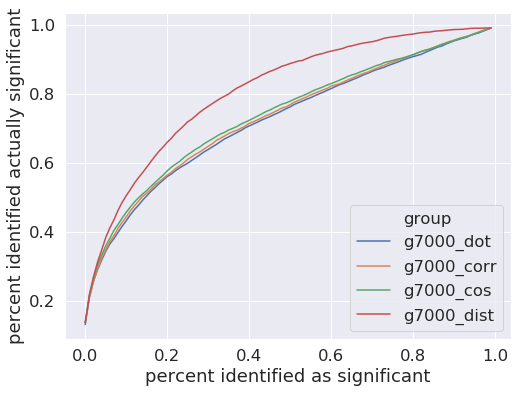

In [69]:
plotIndices(tg_summed, ['g7000_dot', 'g7000_corr', 'g7000_cos', 'g7000_dist'], range(12, 16), np.arange(100)/100)